# Problem 2 - Generative Adversarial Networks

In [1]:
import pandas as pd
import numpy as np
import string
import torch
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.autograd.variable import Variable
import matplotlib.pyplot as plt
import time

In [2]:
# Prepare torch gpu
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
# Using GPU device
gpu_device = torch.device("cuda:0")

True
Quadro RTX 5000 with Max-Q Design


### Loading data into tensor

In [3]:
# Transform to tensors
fmnist_transform = transforms.Compose([transforms.ToTensor()])

In [4]:
# Loading the training data for use
fmnist = datasets.FashionMNIST(root="./fashion_mnist", train = True, transform = fmnist_transform, download = True)
data_loader = DataLoader(dataset = fmnist, batch_size = 32, shuffle = True, num_workers = 0)

In [5]:
# Create reverse dictionary
reverse_lookup = {x:y for y,x in data_loader.dataset.class_to_idx.items()}

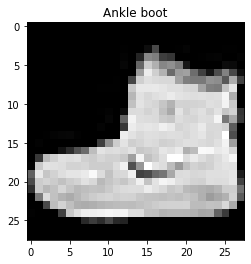

In [6]:
# Plotting the first example to see
_ = plt.imshow(data_loader.dataset.data[0], "gray")
_ = plt.title(reverse_lookup[data_loader.dataset.targets[0].detach().numpy().item()])

In [7]:
reverse_lookup

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

In [8]:
def show_images(torch_gpu_tensors):
    fig = plt.figure(figsize=(14,14))
    for i in range(20):
        p = i + 1
        axes = fig.add_subplot(5,4,p)
        plt.imshow(convert_d(torch_gpu_tensors, "1>2")[i].cpu().detach().numpy(), "gray")
    plt.show()

## Part 1 - Vanilla GAN (10 points)

In [9]:
# Convert from 2d to 1d and 1d to 2d
def convert_d(inputs, mode):
    if mode == "2>1":
        return inputs.view(inputs.size(0), 784)
    elif mode == "1>2":
        return inputs.view(inputs.size(0), 28, 28)
    else:
        return None

In [10]:
# Function to generate random noise
def random_noise(n):
    return torch.randn((n, 32))

In [11]:
# The vannila generator with 3 hidden layers and 1 output layer
class vanilla_gen(nn.Module):
    def __init__(self):
        super(vanilla_gen, self).__init__()
        # Input the noise with 64 values
        self.hidden1 = nn.Sequential(nn.Linear(32, 64), nn.ReLU())
        self.hidden2 = nn.Sequential(nn.Linear(64, 256), nn.ReLU())
        self.hidden3 = nn.Sequential(nn.Linear(256, 512), nn.ReLU())
        self.output_layer = nn.Sequential(nn.Linear(512, 784), nn.Tanh())
        
    def forward(self, x):
        out = self.hidden1(x)
        out = self.hidden2(out)
        out = self.hidden3(out)
        out = self.output_layer(out)
        return out

In [12]:
# Generator training function
def train_v_gen(gen_optimizer, generated_data):
    gen_optimizer.zero_grad()
    p = vanilla_dis_model(generated_data)
    loss = vanilla_loss(p, Variable(torch.ones(generated_data.size(0), 1)).to(gpu_device))
    loss.backward()
    gen_optimizer.step()
    return loss

In [13]:
# The discriminator for the vannila gan
class vanilla_dis(nn.Module):
    def __init__(self):
        super(vanilla_dis, self).__init__()
        # Input the image with 784
        self.hidden1 = nn.Sequential(nn.Linear(784, 512), nn.ReLU())
        self.hidden2 = nn.Sequential(nn.Linear(512, 256), nn.ReLU())
        self.hidden3 = nn.Sequential(nn.Linear(256, 64), nn.ReLU())
        self.output_layer = nn.Sequential(nn.Linear(64, 1), nn.Sigmoid())
        
    def forward(self, x):
        out = self.hidden1(x)
        out = self.hidden2(out)
        out = self.hidden3(out)
        out = self.output_layer(out)
        return out

In [14]:
# Discriminator training funciton
def train_v_dis(dis_optimizer, real_data, generated_data):
    dis_optimizer.zero_grad()
    # Train with real data
    p_real = vanilla_dis_model(real_data)
    loss_real = vanilla_loss(p_real, Variable(torch.ones(real_data.size(0), 1)).to(gpu_device))
    loss_real.backward()
    # Train with generated data
    p_gen = vanilla_dis_model(generated_data)
    loss_generated = vanilla_loss(p_gen, Variable(torch.zeros(generated_data.size(0), 1)).to(gpu_device))
    loss_generated.backward()
    
    dis_optimizer.step()
    
    return loss_real + loss_generated, p_real, p_gen

In [15]:
# The training function
def train_vanilla(gen_model, dis_model, dataloader, gen_optimizer, dis_optimizer, num_epochs):
    # Timing
    time_start = int(round(time.time() * 1000))
    
    # Run all the epochs
    gen_img = []
    all_dis_loss = []
    all_gen_loss = []
    gen_model.train()
    dis_model.train()
    display_epoch = [1, 10, 20, 30, 40, 50]
    for epoch in range(num_epochs):
        # Run both train and test stage in each epoch
        dis_loss = 0.0
        gen_loss = 0.0

        # Load data from dataloader
        for i, data in enumerate(data_loader, 0):
            image_data = data[0].to(gpu_device)
            real_data = Variable(convert_d(image_data, "2>1")).to(gpu_device)
            # Train Discriminator
            generated_data = gen_model(random_noise(real_data.size(0)).to(gpu_device)).detach()
            d_loss, d_p_real, d_p_generated = train_v_dis(dis_optimizer, real_data, generated_data)
            # Train Genereator
            generated_images = gen_model(random_noise(image_data.size(0)).to(gpu_device))
            g_loss = train_v_gen(gen_optimizer, generated_images)

            # Add to loss and accuracy
            dis_loss += d_loss.item()
            gen_loss += g_loss.item()

        epoch_dis_loss = dis_loss / dataloader.dataset.data.size(0)
        epoch_gen_loss = gen_loss / dataloader.dataset.data.size(0)

        all_dis_loss.append(epoch_dis_loss)
        all_gen_loss.append(epoch_gen_loss)

        if (epoch + 1) in display_epoch:
            print("Epoch", str(epoch + 1), "/", str(num_epochs))
            print("Discriminator Loss:", epoch_dis_loss)
            print("Generator Loss:", epoch_gen_loss)
            gen_images = gen_model(random_noise(20).to(gpu_device))
            gen_img.append(gen_images)
            
#         # To prevent mode collapse, manually enter ok to continue
#         if (epoch + 1) in [2, 3]:
#             gen_images = gen_model(random_noise(20).to(gpu_device))
#             show_images(gen_images)
#             input("Please press enter to continue")

        run_loss = 0.0
        run_correct = 0
    
    time_elapsed = int(round(time.time() * 1000)) - time_start
    print ('Total training time is {}ms'.format(time_elapsed))
    return all_dis_loss, all_gen_loss, gen_img

In [16]:
# Set up models and solvers and loss for training
vanilla_gen_model = vanilla_gen()
vanilla_gen_model.to(gpu_device)

vanilla_dis_model = vanilla_dis()
vanilla_dis_model.to(gpu_device)

vanilla_loss = nn.BCELoss()
vanilla_gen_sgd = optim.Adam(vanilla_gen_model.parameters(), lr = 0.00015)
vanilla_dis_sgd = optim.Adam(vanilla_dis_model.parameters(), lr = 0.00015)

In [17]:
v_dis_loss, v_gen_loss, v_gen_pic = train_vanilla(vanilla_gen_model, vanilla_dis_model,
                                                  data_loader, vanilla_gen_sgd, vanilla_dis_sgd, 50)

Epoch 1 / 50
Discriminator Loss: 0.009326885624140656
Generator Loss: 0.12168262243469556
Epoch 10 / 50
Discriminator Loss: 0.018647976613541443
Generator Loss: 0.07148110324144363
Epoch 20 / 50
Discriminator Loss: 0.02094253274699052
Generator Loss: 0.0624036094268163
Epoch 30 / 50
Discriminator Loss: 0.022934019650518896
Generator Loss: 0.054762671530246734
Epoch 40 / 50
Discriminator Loss: 0.023383887501060963
Generator Loss: 0.05222520565191905
Epoch 50 / 50
Discriminator Loss: 0.02273975671082735
Generator Loss: 0.05454953606327375
Total training time is 1886574ms


In [18]:
# Save model
torch.save(vanilla_gen_model.state_dict(), "./vanilla_gen.pth")
torch.save(vanilla_dis_model.state_dict(), "./vanilla_dis.pth")

In [19]:
# # Load model
# vanilla_gen_model = vanilla_gen()
# vanilla_gen_model.load_state_dict(torch.load("./vanilla_gen.pth"))
# vanilla_dis_model = vanilla_dis()
# vanilla_dis_model.load_state_dict(torch.load("./vanilla_dis.pth"))

In [20]:
# Save data
store_v_loss = pd.DataFrame({"Discriminator_loss": v_dis_loss, "Generator_loss": v_gen_loss})
store_v_loss.to_csv("vanilla_result.csv", index = False)
store_v_pic = pd.DataFrame(v_gen_pic)
store_v_pic.to_csv("vanilla_pic.csv", index = False)

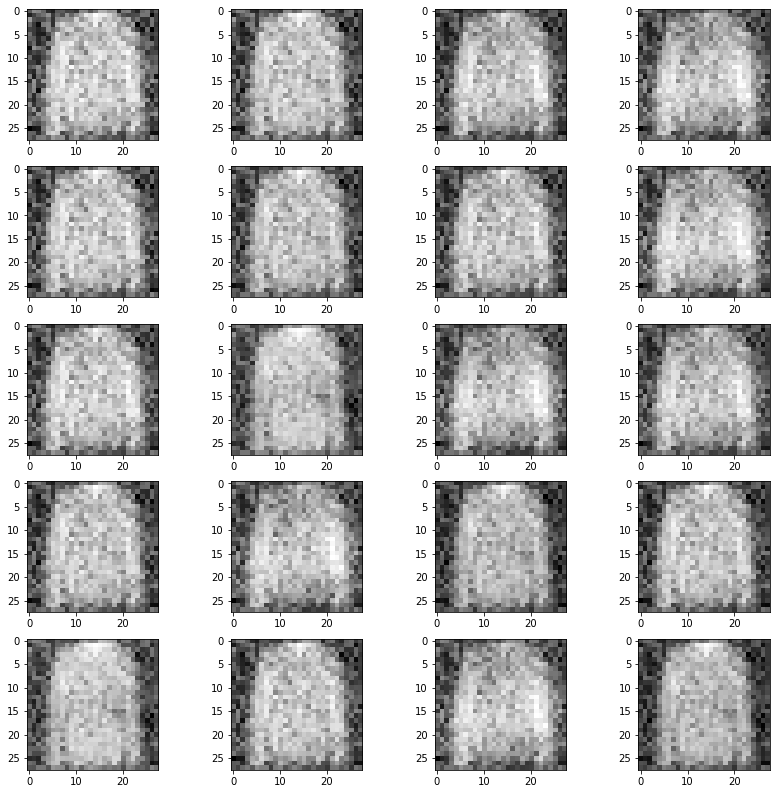

In [21]:
show_images(v_gen_pic[0])

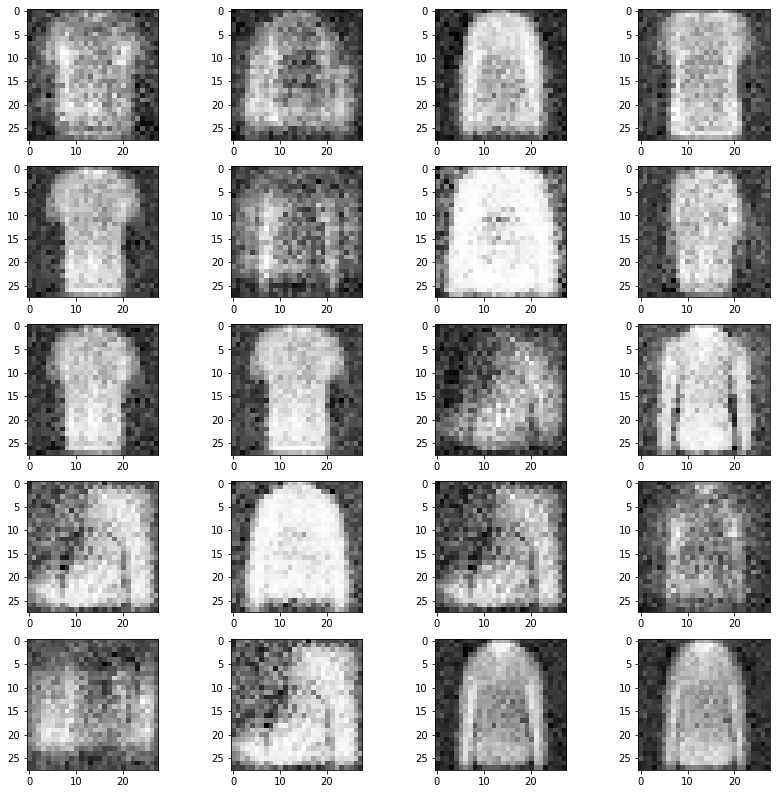

In [30]:
show_images(v_gen_pic[len(v_gen_pic)//2 - 2])

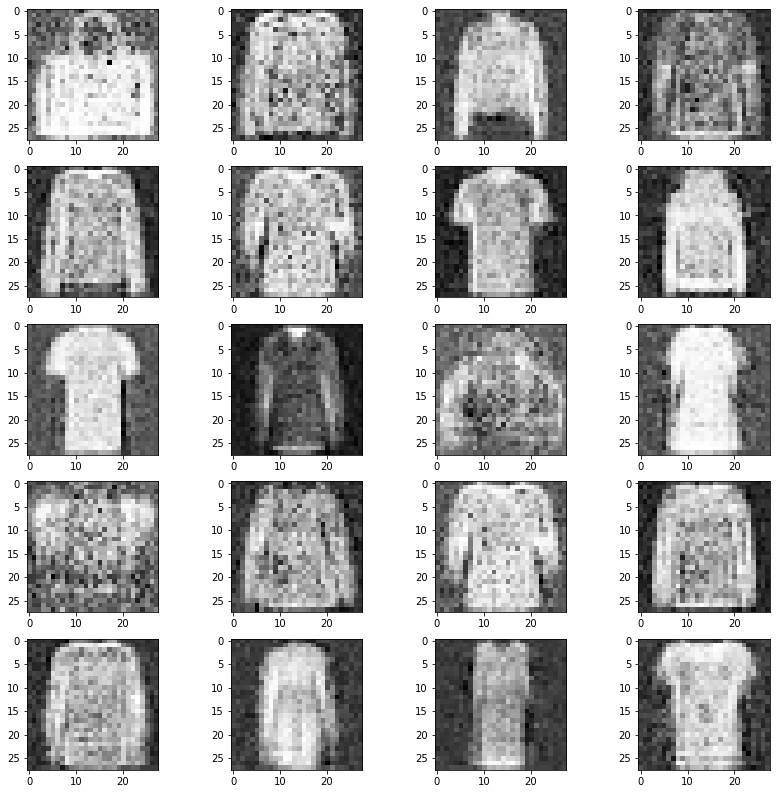

In [23]:
show_images(v_gen_pic[-1])

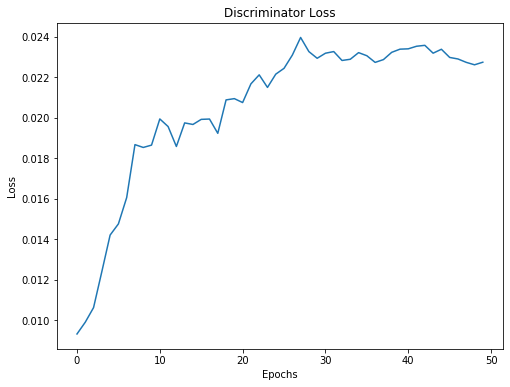

In [24]:
plt.figure(figsize = (8,6))
plt.plot(np.arange(len(v_dis_loss)), v_dis_loss)
_ = plt.title("Discriminator Loss")
_ = plt.xlabel("Epochs")
_ = plt.ylabel("Loss")

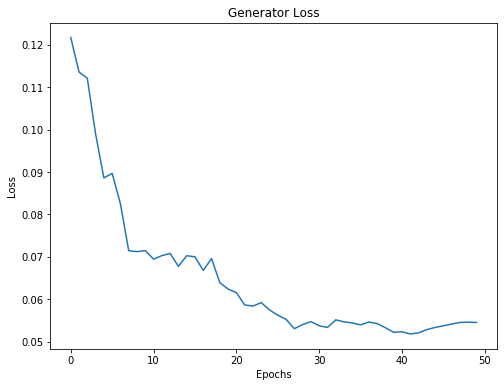

In [25]:
plt.figure(figsize = (8,6))
plt.plot(np.arange(len(v_gen_loss)), v_gen_loss)
_ = plt.title("Generator Loss")
_ = plt.xlabel("Epochs")
_ = plt.ylabel("Loss")